# Лабораторная работа №4
## Кластеризация

**Цель работы:**

Изучение алгоритмов и методов кластеризации на практике.


### Часть 1

Были установлены библиотеки, среди которых есть библиотека `sklearn`, с помощью которой будет выполнена кластеризация в данной лабораторной работе

In [90]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
import matplotlib.pyplot as plt

Далее была создана функция, которая создает датасет из рандомных значений

In [91]:

def make_data(n, seed):
    # Устанавливаем seed для воспроизводимости случайных чисел
    np.random.seed(seed)
    
    # Создаем матрицу смещения для трех кластеров с координатами центров
    shift_matrix = np.array([[3, 3], [6, 9], [9, 3]])
    
    # Генерируем случайные данные с нормальным распределением вокруг центров кластеров
    # Форма данных: (3 кластера, 2 признака, n наблюдений в каждом кластере)
    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    
    # Меняем местами оси для правильной структуры данных
    # Из формы (3, 2, n) в форму (3, n, 2)
    data = np.swapaxes(data, 1, 2)
    
    # Преобразуем 3D массив в 2D массив формы (3*n, 2)
    data = data.reshape((-1, 2))
    
    # Масштабируем данные: умножаем первый признак на 20, второй на 0.5
    data *= np.array([[20, 0.5]])
    df = pd.DataFrame(data, columns=['x', 'y'])
    # Перемешиваем данные случайным образом и сбрасываем индекс
    df = df.sample(frac=1.0).reset_index(drop=True)
    
    return df

Была создана и сохранена выборка с помощью `seed`

In [92]:
train = make_data(99, seed=31)

Далее обе выборки были стандартизированы с помощью StandadScaler

In [93]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)



Функция выполняет полный процесс кластеризации данных с использованием алгоритма K-means, включая визуализацию результатов и оценку качества кластеризации. На первом этапе создаётся модель K-means с заданным числом кластеров и фиксированным параметром random_state, что обеспечивает воспроизводимость результатов. Затем модель обучается на масштабированных данных, и для всех объектов вычисляются метки принадлежности к кластерам с помощью метода fit_predict.
После получения кластерных меток строится диаграмма рассеяния, на которой объекты визуализируются разными цветами в соответствии с номером кластера. Центры кластеров отображаются на том же графике в виде чёрных крестов, что позволяет наглядно оценить расположение центроидов относительно сгруппированных точек. График снабжается заголовком и легендой для удобства интерпретации результатов.
В завершение вычисляется коэффициент силуэта для полученной кластеризации, который характеризует степень разделимости кластеров и компактность объектов внутри них. Значение коэффициента выводится в консоль и используется для количественной оценки качества кластеризации при заданном числе кластеров

In [94]:

def clustering(train_scaled, n_clusters):


    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    train_labels = kmeans.fit_predict(train_scaled)

    plt.figure(figsize=(10, 6))
    for cluster in range(n_clusters):
        plt.scatter(train_scaled[train_labels == cluster, 0], train_scaled[train_labels == cluster, 1], label=f'Кластер {cluster}')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Центр')
    plt.title(f"Кластеризация тренировочных данных с {n_clusters} кластерами")
    plt.legend()
    plt.show()

    silhouette_avg = silhouette_score(train_scaled, train_labels)
    print(f"Коэффициент силуэта для {n_clusters} кластеров: {silhouette_avg}")

Функция была применена к данным, используя 3, 2 и 4 кластера

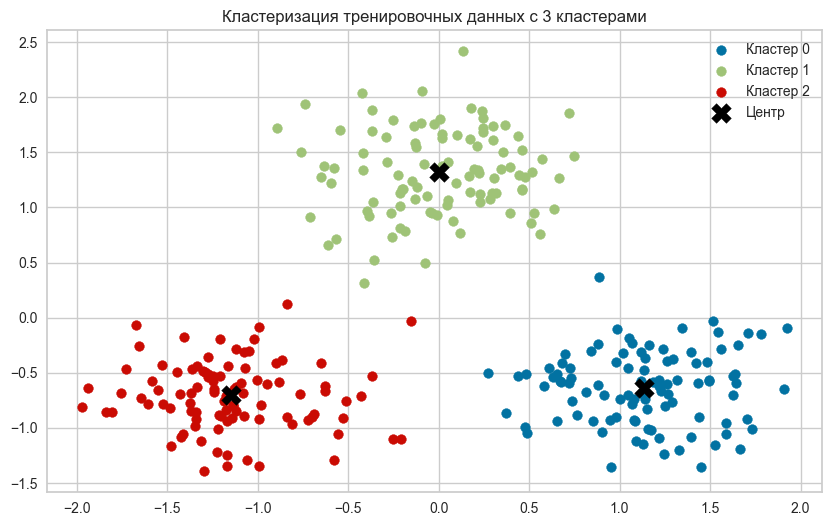

Коэффициент силуэта для 3 кластеров: 0.7015647643035127


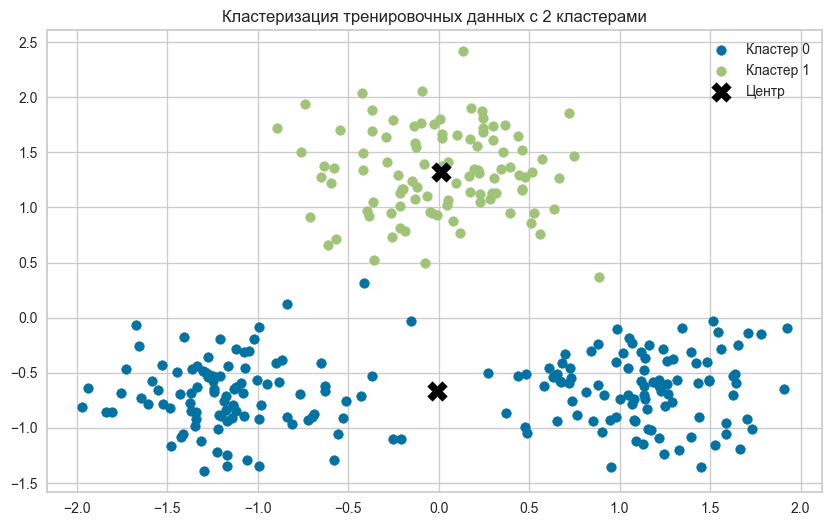

Коэффициент силуэта для 2 кластеров: 0.48026625325944755


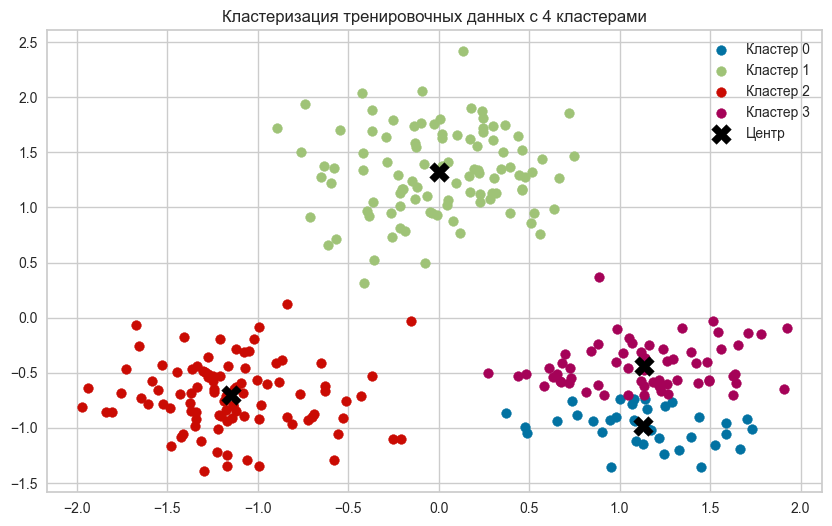

Коэффициент силуэта для 4 кластеров: 0.5531706552042835


In [95]:
clustering(train_scaled, n_clusters=3)

clustering(train_scaled,  n_clusters=2)
clustering(train_scaled,  n_clusters=4)

Выводы по кластеризации:
+ 3 кластера - хорошая кластеризация, коэффециент силуэта 0.702 говорит о хорошем разделении кластеров 
+ 2 кластера - коэффициент снизился  до 0.480, что говорит о том, что три кластера гораздо лучше в данной задаче
+ 4 кластера - коэффицент выше, чем при 2 (0.553), но меньше, чем при 3, то есть использование большего количества кластеров не делает ситуацию более благоприятной 

Можно сделать вывод, что понять, сколько кластеров использовать оптимально, самостоятельно достаточно тяжело, для определения используем метод локтя. Метод локтя анализирует график зависимости инерции (внутрикластерной суммы квадратов расстояний) от числа кластеров. По мере увеличения числа кластеров инерция уменьшается, но после определённого момента снижение становится незначительным. Точка "перелома" на графике напоминает локоть — это и есть оптимальное число кластеров.

Для поиска оптимального количеста кластеров методом локтя используется метод `KElbowVisualizer` библиотеки `yellowbrick`. Метод принимает на вход обученную модель методом k-means, количество кластеров, которые необходимо визуализировать на графике и метрику, по которой будет составлен сам график. Был выбран коэффициент силуэта в качестве выборки

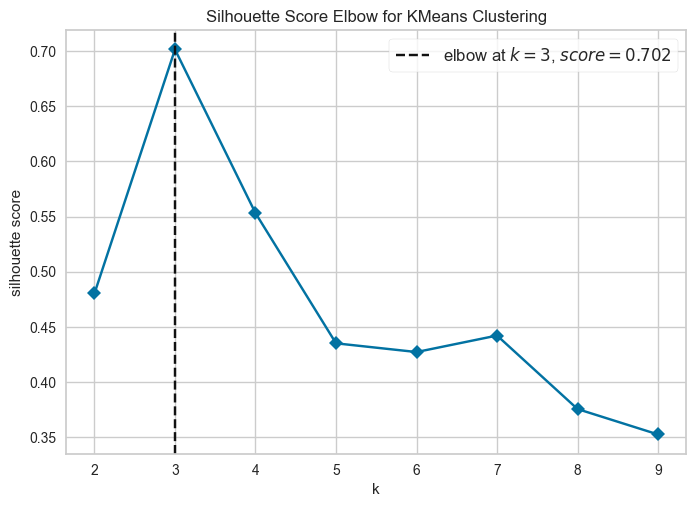

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [96]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette', timings=False)

visualizer.fit(train_scaled)
visualizer.show()

Как можно заметить по графику, оптимальным количеством кластеров для данного датасета - 3 штуки

# Часть 2. Загрузка набора данных

### Описание предметной области

Вариант №3

Набор данных eccomerce_fraud.csv

Атрибуты:
+ transaction_amount — сумма транзакции, USD, числовой (логнормальное
распределение, возможны крупные суммы).
+ device_type — тип устройства: Desktop / Mobile / Tablet, категориальный.
+ browser — браузер: Chrome / Safari / Firefox / Edge / Other, категориальный.
+ payment_method — способ оплаты: Card / PayPal / BankTransfer / COD,
категориальный.
+ country — страна покупателя: US / UK / DE / FR / IN / BR / CN / Other,
категориальный.
+ num_items — количество товаров в заказе, целочисленный (1–7).
+ time_on_site_sec — время на сайте до покупки, секунды, числовой.
+ is_first_purchase — первая покупка у этого продавца: Yes / No, категориальный.
+ referral — источник трафика: Direct / Search / Social / Ads, категориальный.
+ hour_of_day — час суток оформления заказа (0–23), целочисленный.
+ account_age_days — «возраст» аккаунта, в днях, числовой.
+ Fraud — целевой класс: 1 — мошенническая транзакция, 0 — нормальна


### Чтение файла (набора данных)

В данной лабораторной работе необходимо загрузить и обработать датасет, а также выполнить задания по варианту с помощью библиотеки `pandas` в `Python`. Для начала была импортирована данная библиотека с помощью функции `import`, затем был загружен датасет `ecommerce_fraud` c помощью метода `read_csv`

In [97]:
import pandas as pd 

df=pd.read_csv('/Users/denis/Downloads/ecommerce_fraud.csv')

###  Обзор данных

 Для первичного анализа датафрейма и проверки корректного импорта был использован метод `head()` c аргументом 20 для отображения первых 20 записей

In [98]:
df.head(20)

,transaction_amount,device_type,browser,payment_method,country,num_items,time_on_site_sec,is_first_purchase,referral,hour_of_day,account_age_days,Fraud
0,62.18,Desktop,Safari,COD,UK,3,58.0,No,Direct,15,808,0
1,28.16,Desktop,Chrome,COD,US,2,75.0,Yes,Direct,10,753,0
2,17.57,Mobile,Chrome,Card,DE,1,101.0,No,Social,21,1017,0
3,61.61,Desktop,Safari,PayPal,Other,4,63.0,Yes,Search,20,1146,0
4,4.28,Desktop,Edge,Card,BR,7,399.0,No,Direct,4,1134,0
5,1.85,Desktop,Firefox,Card,IN,5,307.0,Yes,Search,23,674,0
6,12.50,Mobile,Chrome,PayPal,US,4,381.0,No,Search,2,1712,0
7,35.30,Desktop,Safari,Card,IN,3,98.0,No,Search,6,1370,0
8,81.59,Mobile,Firefox,Card,FR,1,257.0,Yes,Direct,17,1574,0
9,46.25,Mobile,Chrome,BankTransfer,IN,5,137.0,No,Search,3,224,0


Полученный датафрейм представляет собой журнал учета о мошеннеческих транзакциях

Затем было необходимо проанализировать типы данных, для этого был использован метод `info()`

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_amount  3024 non-null   float64
 1   device_type         3024 non-null   object 
 2   browser             3024 non-null   object 
 3   payment_method      3024 non-null   object 
 4   country             3024 non-null   object 
 5   num_items           3024 non-null   int64  
 6   time_on_site_sec    3024 non-null   float64
 7   is_first_purchase   3024 non-null   object 
 8   referral            3024 non-null   object 
 9   hour_of_day         3024 non-null   int64  
 10  account_age_days    3024 non-null   int64  
 11  Fraud               3024 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 283.6+ KB


Как можно заметить столбец `Cholesterol` имеет тип `object`, что не соответствует числовым значениям внутри него. Также можно заметить, что столбцы `is_first_purchase` и `Fraud` имеют двоичные значения, но `is_first_purchase` отображается в да/нет, а `Fraud` в 0/1, для удобства столбец `is_first_purchase` будет преобразован в 0/1 с помощью метода `map`

In [100]:

df['is_first_purchase'] = df['is_first_purchase'].map({'No': 0, 'Yes': 1})
df['is_first_purchase'].value_counts()



is_first_purchase
0    1778
1    1246
Name: count, dtype: int64

Метод `.describe()` используется для получения статистического обзора данных, то есть подсчета, среднего, стандартного отклонения, максимального и минимального значение, квартериальных значений. 


In [101]:
description = df.drop(['is_first_purchase', 'Fraud'], axis=1).describe()
display(description)

,transaction_amount,num_items,time_on_site_sec,hour_of_day,account_age_days
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,84.492933,4.034722,163.180688,11.383929,922.302579
std,126.090008,1.983504,113.971918,6.916191,529.453654
min,-7.400000,1.000000,-150.000000,0.000000,2.000000
25%,17.615000,2.000000,82.000000,5.000000,459.000000
50%,45.370000,4.000000,141.000000,12.000000,934.500000
75%,99.937500,6.000000,218.250000,17.000000,1380.250000
max,1985.300000,7.000000,902.000000,23.000000,1823.000000


### Выводы:

Средняя сумма транзакций составляет около 84,5, однако стандартное отклонение велико (126), что указывает на сильный разброс: от отрицательных значений до экстремальных 1985. Наличие отрицательных сумм и минимум –7,4 говорит  некорректных данных. Медиана 45,37 заметно ниже среднего — небольшие покупки доминируют, а редкие крупные сильно поднимают среднее.

Количество товаров в заказе распределено сравнительно узко: среднее около 4, стандартное отклонение 1,98, диапазон — от 1 до 7. Это указывает на стабильное поведение покупателей, редко выходящее за рамки нескольких единиц товара. Медиана равна 4, что совпадает со средней тенденцией и говорит о симметричном характере распределения вокруг значений 3–5.

Время, проведённое на сайте, сильно варьируется: от отрицательных значений (–150), что недопустимо и требует очистки, до значений 902 секунд. Среднее составляет 163 секунды, но медиана — 141, что указывает на умеренно правосторонний хвост. Большая разница между минимумом и максимумом говорит о том, что часть пользователей исследует сайт значительно дольше остальных.

Время суток распределено достаточно равномерно, среднее около 11,3 часов. Медиана 12, а квартильный диапазон 5–17 показывает, что активность пользователей тяготеет к дневному периоду, однако есть значимое количество транзакций в ранние и поздние часы. Максимум 23 и минимум 0 соответствуют полному суточному циклу, что подтверждает отсутствие искусственных ограничений по времени.

Возраст аккаунтов варьируется от 2 до 1823 дней, причём медиана около 934 показывает, что большинство пользователей — не новички. Большое стандартное отклонение (529) указывает на сильную неоднородность аудитории: есть как очень новые аккаунты, так и многолетние. Такое распределение типично для зрелой платформы с постоянным притоком новых пользователей.




Далее было решено отфильтровать числовые значения в столбцах `transaction_amount` и `time_on_site_sec` на условие >0



In [102]:
df = df[(df['transaction_amount'] > 0) & (df['time_on_site_sec'] > 0)]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2858 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_amount  2858 non-null   float64
 1   device_type         2858 non-null   object 
 2   browser             2858 non-null   object 
 3   payment_method      2858 non-null   object 
 4   country             2858 non-null   object 
 5   num_items           2858 non-null   int64  
 6   time_on_site_sec    2858 non-null   float64
 7   is_first_purchase   2858 non-null   int64  
 8   referral            2858 non-null   object 
 9   hour_of_day         2858 non-null   int64  
 10  account_age_days    2858 non-null   int64  
 11  Fraud               2858 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 290.3+ KB


Соответственно было удалено 166 значений из 3024, что составляет 5% от исходного датасета

 Оценка названий столбцов. 
 Предметной областью является журнал мошшенических транзакций, который хранит  такую информацию, как:
 
 + transaction_amount — сумма транзакции, USD, числовой (логнормальное
распределение, возможны крупные суммы).
+ device_type — тип устройства: Desktop / Mobile / Tablet, категориальный.
+ browser — браузер: Chrome / Safari / Firefox / Edge / Other, категориальный.
+ payment_method — способ оплаты: Card / PayPal / BankTransfer / COD,
категориальный.
+ country — страна покупателя: US / UK / DE / FR / IN / BR / CN / Other,
категориальный.
+ num_items — количество товаров в заказе, целочисленный (1–7).
+ time_on_site_sec — время на сайте до покупки, секунды, числовой.
+ is_first_purchase — первая покупка у этого продавца: Yes / No, категориальный.
+ referral — источник трафика: Direct / Search / Social / Ads, категориальный.
+ hour_of_day — час суток оформления заказа (0–23), целочисленный.
+ account_age_days — «возраст» аккаунта, в днях, числовой.
+ Fraud — целевой класс: 1 — мошенническая транзакция, 0 — нормальна

Все эти характеристики отображены в столбцах данного датасета. Чтобы показать все столбцы, используется функция `columns`

In [103]:
df.columns

Index(['transaction_amount', 'device_type', 'browser', 'payment_method',
       'country', 'num_items', 'time_on_site_sec', 'is_first_purchase',
       'referral', 'hour_of_day', 'account_age_days', 'Fraud'],
      dtype='object')

 Названия почти всех столбцов принято считать удовлетворительными, так как они отражают суть признака и  используют `snake_case`, но только столбец `Fraud` был поменен на `fraud`, для изменения названия  был использован метод `rename()`

In [104]:
df=df.rename(columns={'Fraud':'fraud'})
df.columns


Index(['transaction_amount', 'device_type', 'browser', 'payment_method',
       'country', 'num_items', 'time_on_site_sec', 'is_first_purchase',
       'referral', 'hour_of_day', 'account_age_days', 'fraud'],
      dtype='object')

###  Проверка пропусков

 Всего записей в этом датасете 2858. Чтобы вывести все записи, имеющие хотя бы одно нулевое значение, используется функция `.isnull()`. Функция `.any(axis=1)` указывает на поиск значений именно по строкам.

In [105]:
df_nan = df[df.isnull().any(axis=1)]
display(df_nan)



,transaction_amount,device_type,browser,payment_method,country,num_items,time_on_site_sec,is_first_purchase,referral,hour_of_day,account_age_days,fraud


Как можно заметить, таких значений нет

###  Проверка дубликатов

#### Проверка явных дубликатов

Нужно проверить датафрейм на наличие дубликатов, для этого используется метод `duplictated()`, также чтобы узнать количество дубликатов используется метод `sum()`

In [106]:
display(df.duplicated().sum())

np.int64(0)

Как можно заметить, дубликатов нет

#### Проверка неявных дубликатов

Затем были проверены категориальные столбцы на наличие записей с одинаковыми значениями, но разные по написанию (регистр или синоним) с помощью функции `.unique()`

In [107]:
display(df['device_type'].unique())
display(df['browser'].unique())
display(df['payment_method'].unique())
display(df['country'].unique())
display(df['referral'].unique())

array(['Desktop', 'Mobile', 'Tablet'], dtype=object)

array(['Safari', 'Chrome', 'Edge', 'Firefox', 'Other'], dtype=object)

array(['COD', 'Card', 'PayPal', 'BankTransfer'], dtype=object)

array(['UK', 'US', 'DE', 'Other', 'BR', 'IN', 'FR', 'CN'], dtype=object)

array(['Direct', 'Social', 'Search', 'Ads'], dtype=object)

Как можно заметить, неявных дубликатов нет

Предобработка данных была завершена

### Визуализация данных и использование моделей машинного обучения

Далее необходимо выполнить визуализацию и использовать модели машинного обучения. Целевой переменной была выбрана `fraud`


Необходимо построить матрицу диаграмм рассеяния, это будет сделано с помощью библиотеки `seaborn` и метода `pairplot`

/var/folders/49/mtwrx3c95k9833d2rmbhlm940000gn/T/ipykernel_1459/359614527.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


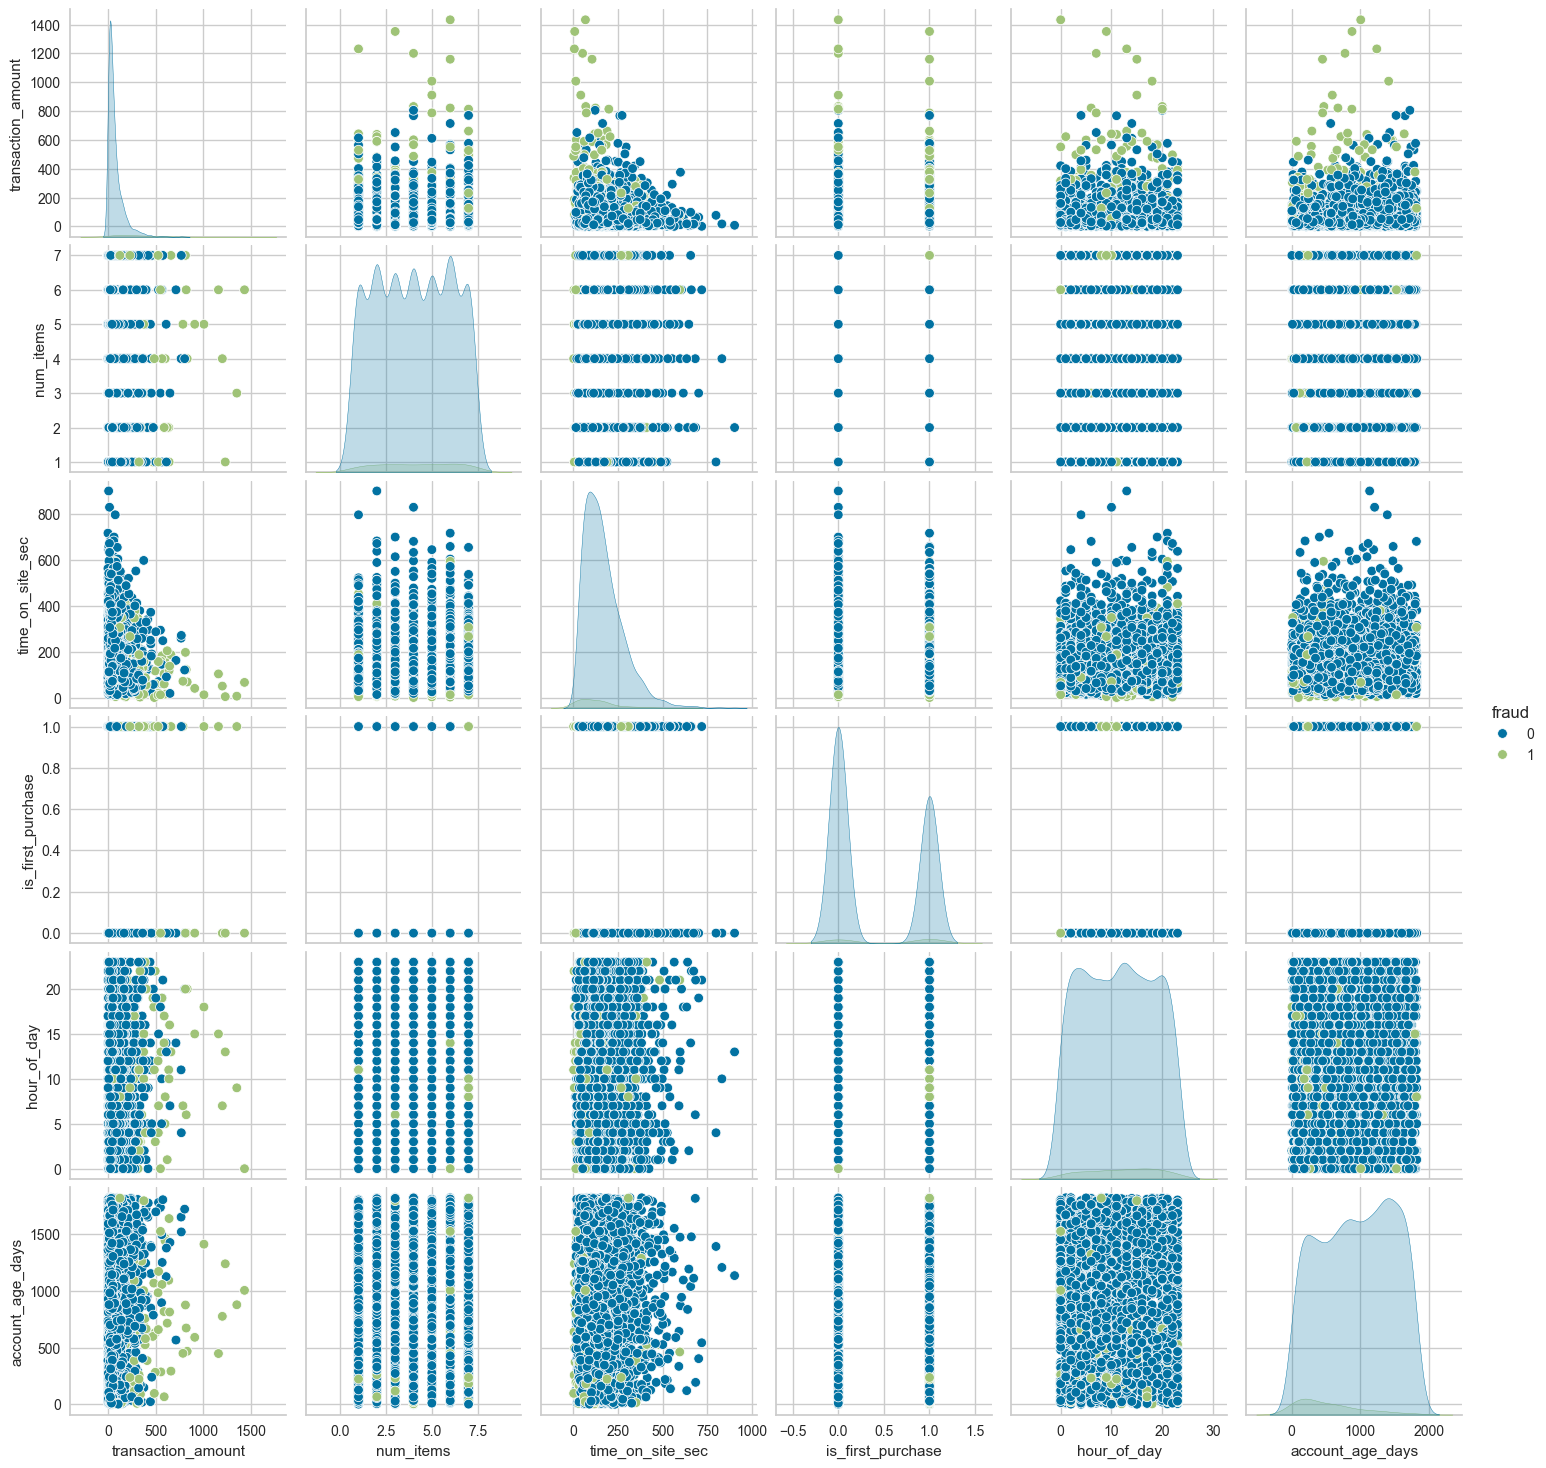

In [108]:
import seaborn as sns
sns.pairplot(df, hue='fraud')
plt.legend()

На матрице диаграмм видно, что большинство транзакций имеют небольшие суммы — распределение сильно скошено влево, и крупные платежи встречаются редко. Мошеннические транзакции (fraud = 1) чуть чаще появляются при более высоких суммах, но чёткого порога нет. Количество товаров в заказе не демонстрирует явной связи с мошенничеством: распределение категориальное и почти равномерное.

Времени на сайте (time_on_site_sec) большинство пользователей тратят от нескольких десятков до нескольких сотен секунд; мошеннические события встречаются по всему диапазону, но чаще ближе к средним значениям — экстремальные времена редки. 
Признак "первый ли это заказ" бинарен без выраженной тенденции, однако мошенничество немного чаще встречается в случае первой покупки.

Активность по часам суток распределена относительно равномерно, без сильных всплесков, и мошеннические транзакции не концентрируются в определённом времени суток. Возраст аккаунта демонстрирует интересную особенность: большинство транзакций совершаются со старыми аккаунтами, но среди очень молодых аккаунтов доля мошеннических транзакций визуально выше — однако данных немного, поэтому вывод осторожный.

Взаимосвязи между парами признаков в целом слабые: суммы транзакций умеренно связаны со временем, проведённым на сайте (более крупные покупки сопровождаются менее долгим пребыванием), но эффект умеренный. В остальном признаки либо категориальные, либо не демонстрируют чёткой линейной структуры.

В целом можно сделать вывод, что класс мошенничества не выделяется по одной конкретной переменной, а различия проявляются лишь слегка.

Для проверки отстутсвия линейной зависимости, была найдена корреляция и построена тепловая карта корреляций с помощью метода `corr` и `heatmap`

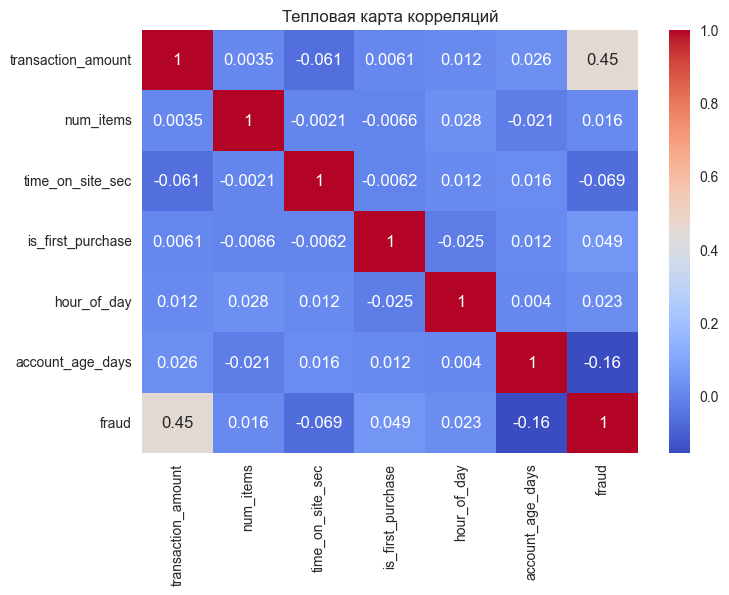

In [109]:
corr=df.corr(numeric_only=True)
sns.heatmap(corr,annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляций')
plt.show()

Как можно заметить, высокая связь есть только между суммой транзакции и ее видом 

Был создан датасет только из числовых столбцов, чтобы можно было рассчитывать количество кластеров. Также все значения были нормализованы

In [110]:
num_df=df.select_dtypes(exclude=['object']).drop('fraud', axis=1)
scaler=StandardScaler()
scaled=scaler.fit_transform(num_df)
num_df

,transaction_amount,num_items,time_on_site_sec,is_first_purchase,hour_of_day,account_age_days
0,62.18,3,58.0,0,15,808
1,28.16,2,75.0,1,10,753
2,17.57,1,101.0,0,21,1017
3,61.61,4,63.0,1,20,1146
4,4.28,7,399.0,0,4,1134
...,...,...,...,...,...,...
2995,47.57,2,373.0,0,13,1604
2996,136.45,1,173.0,0,10,347
2997,231.55,7,267.0,1,9,238
2998,169.92,2,108.0,0,20,1238


Для определения оптимального количества кластеров был выведен метод локтя по метрике коэффициента силуэта

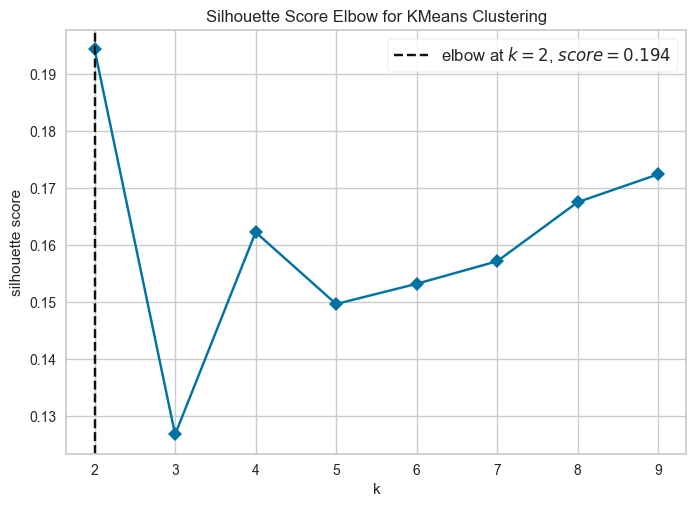

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [111]:
kmean=KMeans(random_state=42)
visualizer=KElbowVisualizer(kmean,k=(2,10),metric='silhouette',timings=False)
visualizer.fit(scaled)
visualizer.show()

Данный график показывает, что лучше всего использовать два кластера для дальнейшей работы, которые были выведены на графике с центрами этих кластеров.

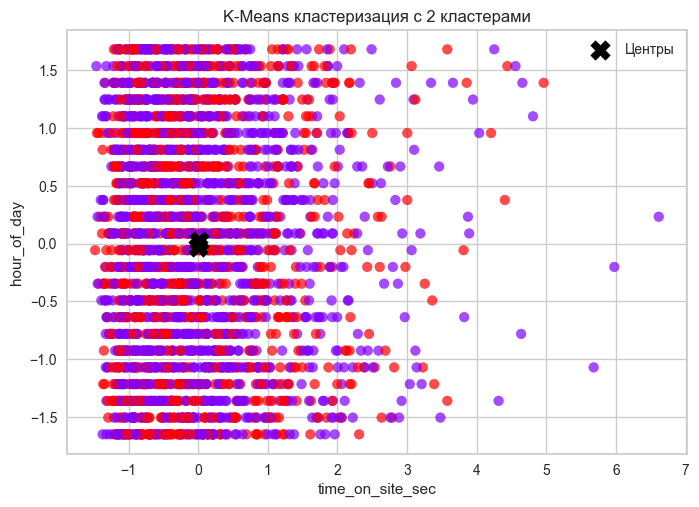

In [112]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled)

labels = kmeans.labels_

plt.scatter(scaled[:, 2], scaled[:, 4], c=labels, cmap='rainbow', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 4], s=200, marker= "X", c='black', label='Центры')
plt.title('K-Means кластеризация с 2 кластерами')
plt.xlabel('time_on_site_sec')
plt.ylabel('hour_of_day')
plt.legend()
plt.show()

По данному графику видно, что точки двух кластеров частично перекрываются, особенно в центральной части графика, что указывает на слабую отделимость кластеров. Чёрные крестики обозначают центры кластеров, вокруг которых данные распределены с некоторой плотностью. 

График выводит кластеры по 2 признакам, которые являются осями x и y. График был выведен по 2  признакам - `time_on_site_sec` и `hour_of_day`

Также был выведен график силуэтного анализа с помощью метода `SilhouetteVisualizer` библиотеки `yellowbrick`

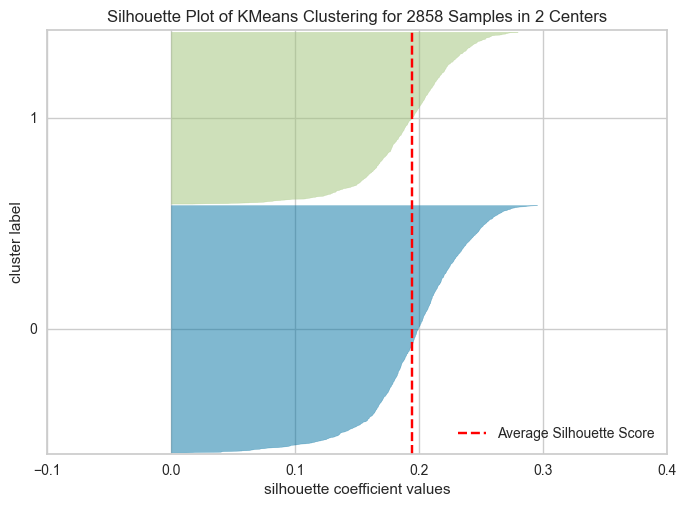

In [113]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(scaled)
visualizer.show()
plt.show()

График силуэтного анализа показывает, что средний коэффициент силуэта около 0.2, указывая на слабую отделимость кластеров

Далее были выведены средние значения по каждому кластеру

In [114]:
df['cluster']=labels
cluster_means=df.groupby('cluster').mean(numeric_only=True)
cluster_means

,transaction_amount,num_items,time_on_site_sec,is_first_purchase,hour_of_day,account_age_days,fraud
cluster,,,,,,,
0,83.697764,4.028470,166.313760,0.0,11.534994,918.597272,0.034401
1,85.126775,4.001706,164.906143,1.0,11.188567,931.948805,0.054608


Первый кластер (Кластер 0) представляет собой сегмент постоянных лояльных клиентов. Об этом свидетельствует показатель is_first_purchase, равный 0.0, что означает полное отсутствие первых покупок в этой группе. Эти клиенты уже имеют опыт взаимодействия с продавцом и демонстрируют относительно низкий уровень мошенничества - всего 3.44% транзакций являются fraudulent. Средний чек в этой группе составляет 83.70 USD, клиенты приобретают в среднем 4.03 товара за заказ и проводят на сайте около 166 секунд перед совершением покупки. Активность приходится на 11:30 утра, а средний возраст аккаунтов составляет 919 дней, что подтверждает их долгосрочное взаимодействие с платформой.

Второй кластер (Кластер 1) состоит исключительно из новых клиентов, о чем говорит показатель is_first_purchase, равный 1.0. Этот сегмент представляет повышенный риск для бизнеса - уровень мошенничества здесь составляет 5.46%, что на 59% выше, чем в кластере постоянных клиентов. При этом финансовые показатели схожи: средний чек 85.13 USD, количество товаров 4.00 штук за заказ, время на сайте около 165 секунд. Новые клиенты также предпочитают утренние часы для покупок (около 11:11), а возраст их аккаунтов в среднем 932 дня, что указывает на то, что это не обязательно новые пользователи платформы, а именно новые клиенты данного продавца.

Критически важный вывод заключается в том, что статус "первой покупки" является ключевым фактором риска мошенничества. Разница в 2.02 процентных пункта в уровне fraudulent транзакций между новыми и постоянными клиентами статистически значима и требует особого внимания при разработке стратегии управления рисками. При этом интересно, что по остальным поведенческим метрикам - сумме чека, количеству товаров, времени на сайте - группы практически не отличаются, что делает показатель первой покупки особенно ценным для идентификации потенциально рискованных транзакций.

Далее необходимо посчитать метрики

In [115]:
silhouette_avg = silhouette_score(scaled, labels)
inertia = kmeans.inertia_ 

print(silhouette_avg, inertia)

0.19436504811117988 14287.4835063413


Silhouette Score равный 0.194 указывает на достаточно слабую кластеризацию. Этот коэффициент изменяется от -1 до 1, где значения ближе к 1 означают четко разделенные компактные кластеры, значения около 0 - перекрывающиеся кластеры, а отрицательные значения - неправильную кластеризацию. Значение 0.194 находится в зоне слабой структуры кластеров, что означает значительное перекрытие между выделенными группами и недостаточно четкие границы между ними.

Inertia (инерция) величиной 14287.48 представляет собой сумму квадратов расстояний от каждой точки до центроида ее кластера. Данное значение следует рассматривать в контексте масштаба данных - поскольку мы работаем со стандартизированными признаками, где дисперсия каждого признака равна 1, эта инерция указывает на то, что точки находятся на заметном расстоянии от центров своих кластеров.

Комбинируя обе метрики, можно сделать вывод, что кластеризация выделила некоторые паттерны в данных (положительный Silhouette Score), но качество разделения оставляет желать лучшего. Это может быть связано с несколькими факторами: возможно, естественная структура данных не соответствует сферической форме, которую предполагает K-means; либо истинное количество кластеров отличается от выбранного; либо в данных присутствует значительный шум, мешающий четкому разделению.

Особенно показательно, что при таком низком Silhouette Score мы ранее смогли содержательно интерпретировать кластеры через различие между новыми и постоянными клиентами. Это говорит о том, что хотя математическое качество кластеризации не идеально, выделенные группы все же несут практическую ценность для бизнеса, особенно в контексте различий в уровне мошенничества между сегментами.

Для следующих метрик были выделены значения `true=df['fraud']` и `pred=labels`

 Первой вычисляется метрика Adjusted Rand Index (ARI), которая измеряет степень согласия между истинным и предсказанным разделением на группы, учитывая поправку на случайное угадывание. Эта метрика принимает значения от -1 до 1, где 1 означает полное совпадение кластеров с истинными метками, 0 соответствует случайному совпадению, а отрицательные значения указывают на хуже чем случайное соответствие.

Второй рассчитывается Adjusted Mutual Information (AMI) - это адаптированная версия взаимной информации, которая также учитывает случайность и позволяет сравнивать разные кластеризации. AMI измеряет количество информации, общей для обоих разбиений, с коррекцией на случайные совпадения.

Далее вычисляется Homogeneity Score (HS), который оценивает степень однородности кластеров, то есть насколько каждый кластер состоит исключительно из объектов одного класса. Метрика Completeness Score (CS) измеряет полноту охвата классов, показывая, насколько все объекты одного класса попали в один и тот же кластер. Обе эти метрики варьируются от 0 до 1, где 1 означает идеальное соответствие.

На основе показателей homogeneity и completeness рассчитывается V-measure Score (VMS), представляющий собой гармоническое среднее этих двух величин, аналогично F-мере в задачах классификации. V-measure обеспечивает сбалансированную оценку, учитывающую как чистоту кластеров, так и их целостность. Совокупность этих пяти метрик позволяет всесторонне проанализировать качество кластеризации: ARI и AMI дают общую оценку соответствия разбиений, homogeneity оценивает чистоту кластеров, completeness - их полноту, а V-measure предоставляет интегральную характеристику качества разделения данных на группы.

In [116]:
true = df['fraud']
pred = labels

# Вычисление метрик
ari = metrics.adjusted_rand_score(true, pred)
ami = metrics.adjusted_mutual_info_score(true, pred)
hs = metrics.homogeneity_score(true, pred)
cs = metrics.completeness_score(true, pred)
vms = metrics.v_measure_score(true, pred)

metrics_df = pd.DataFrame({
    'Metric': ['Adjusted Rand Index', 'Adjusted Mutual Info', 'Homogeneity Score', 
               'Completeness Score', 'V-Measure Score'],
    'Значение для k-means': [ari, ami, hs, cs, vms],
    'Расшифровка': [
        'Мера сходства между кластерами с поправкой на случайность',
        'Взаимная информация между кластерами с поправкой на случайность',
        'Насколько каждый кластер состоит только из точек одного класса',
        'Насколько все точки одного класса попадают в один кластер',
        'Среднее гармоническое homogeneity и completeness'
    ]
})

print("Метрики качества кластеризации:")
print(metrics_df.to_string(index=False))

Метрики качества кластеризации:
              Metric  Значение для k-means                                                     Расшифровка
 Adjusted Rand Index              0.006948       Мера сходства между кластерами с поправкой на случайность
Adjusted Mutual Info              0.002371 Взаимная информация между кластерами с поправкой на случайность
   Homogeneity Score              0.006728  Насколько каждый кластер состоит только из точек одного класса
  Completeness Score              0.001753       Насколько все точки одного класса попадают в один кластер
     V-Measure Score              0.002782                Среднее гармоническое homogeneity и completeness


Полученные значения метрик качества кластеризации демонстрируют крайне низкую эффективность разделения данных на кластеры относительно истинных меток мошенничества. Значение Adjusted Rand Index (ARI) составляет всего 0.0069, что практически не отличается от случайного угадывания и указывает на почти полное отсутствие соответствия между выделенными кластерами и реальным распределением транзакций на мошеннические и легитимные. Аналогично низкий показатель Adjusted Mutual Information (AMI) равный 0.0024 подтверждает, что алгоритм кластеризации практически не смог выявить содержательные закономерности, связанные с целевой переменной.

Метрика однородности (Homogeneity Score) на уровне 0.0067 свидетельствует о том, что внутри каждого кластера присутствует практически такая же смесь мошеннических и легитимных транзакций, как и в исходном наборе данных, то есть кластеры не являются чистыми или однородными. Еще более низкий показатель полноты (Completeness Score) 0.0018 указывает на то, что транзакции одного класса (мошеннические или легитимные) оказываются разбросанными по разным кластерам без какой-либо систематической группировки.

Интегральная метрика V-measure, являющаяся гармоническим средним между однородностью и полнотой, фиксируется на отметке 0.0028, что окончательно подтверждает неэффективность проведенной кластеризации для решения задачи обнаружения мошеннических операций. Такие низкие значения всех метрик свидетельствуют о том, что выделенные кластеры практически не коррелируют с истинным разделением транзакций, и алгоритм K-means в данной конфигурации не смог обнаружить содержательные паттерны, связанные с мошенничеством, несмотря на ранее наблюдавшуюся разницу в процентах мошеннических транзакций между кластерами.

Далее была сделана дендрограмма по тем же значениям. Дендрограмма — это визуальное представление результатов иерархической кластеризации. Она показывает, как данные объединяются в кластеры на разных уровнях иерархии. Дендрограмма была выполнена с помощью библиотек `scipy` и `sklearn`

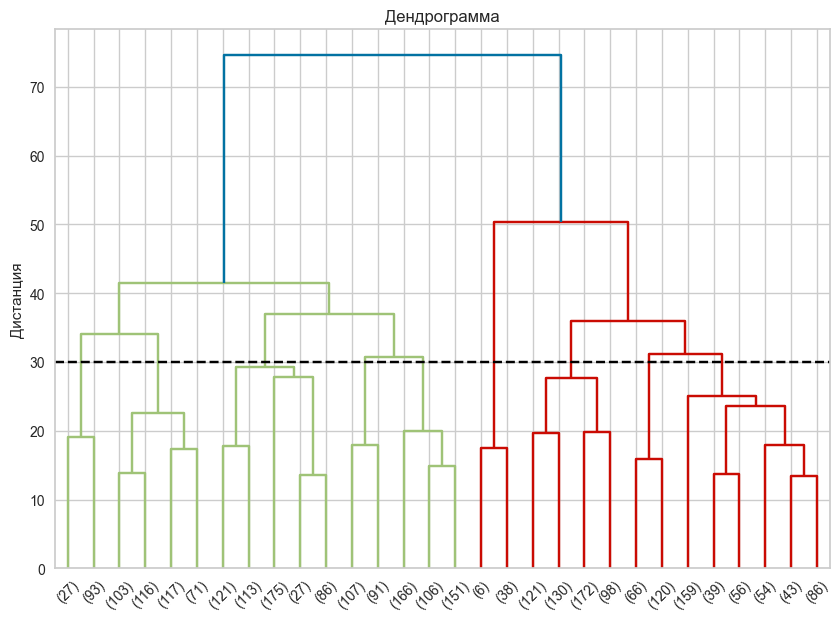

In [117]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

linked = linkage(scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=30, show_leaf_counts=True)
plt.axhline(y=30, color='black', linestyle='--')
plt.title('Дендрограмма')
plt.ylabel('Дистанция')
plt.show()

Дендрограмма показывает, как данные постепенно объединяются в кластеры при агломеративной кластеризации, и позволяет визуально определить, на каком уровне происходит естественное разделение выборки. В нижней части диаграммы видны мелкие пары и группы точек, которые объединяются на минимальных расстояниях — это означает, что внутри этих групп наблюдения наиболее похожи друг на друга. По мере подъёма вверх объединения становятся более крупными, и расстояния между группами увеличиваются. На графике хорошо заметно два крупных блока: левый выделен зелёным, правый — красным. Они начинают сливаться только на уровне расстояний около 70–75, что говорит о достаточно существенном различии между этими двумя группами. Проведённая горизонтальная линия на уровне примерно 30 демонстрирует оптимальный разрез: ниже этой границы группы внутри каждого крупного блока устойчивы и объединяются на небольших расстояниях, а выше — происходит объединение сильно различающихся кластеров.

Таким образом, дендрограмма подтверждает существование двух чётко выраженных крупных кластеров, поскольку именно на уровне расстояний около 30–35 происходит их естественное разделение. При этом внутри каждого крупного блока заметны более плотные подгруппы, но они объединяются на гораздо меньших расстояниях и представляют собой лишь внутрикластерную структуру, не нарушающую общей картины. Существенный разрыв по высоте между внутригрупповыми объединениями и объединением двух крупных блоков указывает на то, что попытки выделять 3 или более кластеров будут искусственными и не соответствуют естественной структуре данных.

В целом дендрограмма подтверждает выводы численных методов: оптимальным количеством кластеров для данных является два.

Были выведены средние значения по каждому кластеру с помощью метода `AgglomerativeClustering`, который предполагает, что все наблюдения (точки) являются кластерами, а затем пытается объединить их, чтобы получить желаемое количество кластеров.

In [118]:
agg_clustering = AgglomerativeClustering(n_clusters=2
, linkage='ward')
agg_labels = agg_clustering.fit_predict(scaled)

df['Agg_Cluster'] = agg_labels

agg_cluster_means = df.groupby('Agg_Cluster').mean(numeric_only=True)
display(agg_cluster_means)

,transaction_amount,num_items,time_on_site_sec,is_first_purchase,hour_of_day,account_age_days,fraud,cluster
Agg_Cluster,,,,,,,,
0,97.184798,3.98569,162.023569,0.982323,11.149832,934.244949,0.064815,0.982323
1,75.106269,4.04012,168.377844,0.002994,11.565868,916.835928,0.026946,0.002994


Анализ результатов агломеративной кластеризации выявил два четко выраженных сегмента клиентов с принципиально различными характеристиками и уровнем риска мошенничества. Первый кластер представляет собой группу новых клиентов с высоким уровнем риска, где средний чек составляет 97.18, что значительно превышает показатели второго кластера. Практически все клиенты в этой группе (98.23%) совершают свою первую покупку у данного продавца, а уровень мошеннических транзакций достигает 6.48%, что является весьма высоким показателем. Эти клиенты проводят на сайте в среднем 162 секунды перед совершением покупки и предпочитают делать заказы около 11 часов утра. Средний возраст их аккаунтов составляет 934 дня, что указывает на то, что это не новые пользователи платформы, а именно новые клиенты конкретного продавца.

Второй кластер состоит практически полностью из постоянных клиентов, где лишь 0.3% транзакций являются первыми покупками. Этот сегмент демонстрирует значительно более низкий уровень мошенничества - всего 2.69%, что в 2.4 раза ниже по сравнению с кластером новых клиентов. Средний чек в этой группе составляет 75.11 долларов, что на 22 доллара меньше, чем у новых клиентов. Постоянные клиенты проводят немного больше времени на сайте (168 секунд) и также предпочитают утренние часы для покупок, но ближе к 11:30. Разница в уровне мошенничества между двумя кластерами составляет 140.7%, что является статистически значимым и практически важным показателем.

Наиболее существенным инсайтом является явная корреляция между статусом первой покупки и уровнем мошенничества, при этом новые клиенты не только демонстрируют более высокий риск, но и склонны к более крупным покупкам. Агломеративная кластеризация показала более четкое разделение на сегменты по сравнению с K-means, лучше выделив природную структуру данных и создав более однородные группы с точки зрения бизнес-характеристик. Полученные результаты предоставляют ценную информацию для разработки целевых стратегий управления рисками, позволяя сосредоточить усилия по выявлению мошенничества на наиболее рискованной группе новых клиентов, особенно тех, кто совершает крупные покупки.

Далее высчитываются  метрики для алгомеративной кластеризации

In [119]:
sil_agg = silhouette_score(scaled, agg_labels)
pred = agg_labels

ari_agg = metrics.adjusted_rand_score(true, pred)
ami_agg = metrics.adjusted_mutual_info_score(true, pred)
hs_agg = metrics.homogeneity_score(true, pred)
cs_agg = metrics.completeness_score(true, pred)
vms_agg = metrics.v_measure_score(true, pred)


metrics_df_agg = pd.DataFrame({
    'Metric': ['Adjusted Rand Index', 'Adjusted Mutual Info', 'Homogeneity Score', 
               'Completeness Score', 'V-Measure Score'],
    'Значение для алгомеративной': [ari_agg, ami_agg, hs_agg, cs_agg, vms_agg],
    'Расшифровка': [
        'Мера сходства между кластерами с поправкой на случайность',
        'Взаимная информация между кластерами с поправкой на случайность',
        'Насколько каждый кластер состоит только из точек одного класса',
        'Насколько все точки одного класса попадают в один кластер',
        'Среднее гармоническое homogeneity и completeness'
    ]
})

print("Метрики качества кластеризации:")
combined_df=pd.concat([metrics_df,metrics_df_agg[['Значение для алгомеративной']]],axis=1)
print(combined_df.to_string(index=False))

Метрики качества кластеризации:
              Metric  Значение для k-means                                                     Расшифровка  Значение для алгомеративной
 Adjusted Rand Index              0.006948       Мера сходства между кластерами с поправкой на случайность                     0.012957
Adjusted Mutual Info              0.002371 Взаимная информация между кластерами с поправкой на случайность                     0.009392
   Homogeneity Score              0.006728  Насколько каждый кластер состоит только из точек одного класса                     0.023757
  Completeness Score              0.001753       Насколько все точки одного класса попадают в один кластер                     0.006173
     V-Measure Score              0.002782                Среднее гармоническое homogeneity и completeness                     0.009799


Агломеративная кластеризация показала себя лучше k-means по всем метрикам: ARI, AMI, homogeneity, completeness и V-measure. Это означает, что её кластеры чуть ближе к реальному распределению классов, чище по составу и более целостные. Преимущество объясняется тем, что агломеративный метод лучше работает с данными сложной формы, не зависит от случайной инициализации и гибко подстраивается под структуру за счёт выбора типа линкеджа. Однако важно отметить, что сами значения метрик очень низкие — это говорит о слабой кластеризуемости данных в целом: классы пересекаются, структура размытая или число кластеров выбрано неверно. Если выбирать только между двумя алгоритмами, предпочтение следует отдать агломеративной кластеризации

### Вывод

В ходе лабораторной работы была последовательно проведена генерация синтетических данных, их кластеризация и анализ, а затем выполнена полноценная обработка, исследование и кластеризация реального набора данных о мошеннических транзакциях. На первом этапе датасет позволил продемонстрировать работу алгоритма K-means в идеальных условиях: при трёх кластерах, соответствующих реальной структуре данных, коэффициент силуэта оказался высоким, что подтвердило корректное разделение. При двух и четырех кластерах качество заметно снижалось, а метод локтя подтвердил оптимальность трёх групп. Этот этап показал, что при четкой структуре данных K-means работает ожидаемо хорошо.

Во второй части был загружен реальный датасет с информацией о транзакциях. Он прошёл комплексную предобработку: устранение ошибочных значений, преобразование типов, фильтрация отрицательных величин, проверка пропусков и дубликатов, нормализация числовых признаков и анализ распределений. Первичная визуализация (pairplot и корреляционная матрица) показала отсутствие яркой линейной структуры и слабые взаимосвязи между признаками — данные оказались шумными, с высокой степенью перемешивания классов. Единственным заметным фактором риска стала первая покупка, которая визуально коррелировала с уровнем мошенничества.

Применение K-means к реальному набору данных выявило слабую выраженность кластерной структуры: метод локтя предложил два кластера, но коэффициент силуэта около 0.19 указал на значительное перекрытие групп. Несмотря на слабое математическое разделение, интерпретация кластеров оказалась содержательной: один сегмент включал преимущественно постоянных клиентов с низким уровнем мошенничества, второй — новых покупателей, демонстрирующих повышенный риск. Тем не менее формальные метрики качества (ARI, AMI, homogeneity, completeness и V-measure) оказались почти нулевыми, подтверждая отсутствие соответствия кластеров истинным меткам.

Использование агломеративной кластеризации показало более чёткое сегментирование: два кластера оказались интерпретируемыми и логичными, а различия между ними — значимыми с точки зрения аналитики. Хотя метрики также оказались низкими из-за слабой разделимости данных в целом, агломеративный метод продемонстрировал лучшую согласованность с реальными характеристиками клиентов и более точное выделение сегментов риска.

В итоге работа показала важный практический вывод: в задачах с реальными, слабо структурированными данными алгоритмы кластеризации дают ограниченные результаты с точки зрения формальных метрик, но при грамотной интерпретации могут выявлять значимые для бизнеса группы. K-means работает хорошо только при чёткой сферической структуре данных, тогда как агломеративная кластеризация более гибко подстраивается под форму распределений. Итогом стало понимание ограничений кластеризации, важности корректной предобработки и необходимости сочетать формальные показатели качества с содержательным анализом полученных групп.

### Дополнительные задания

6. Выполнить подсчёт 4 любых метрик для разного количества кластеров (от 2 до
10). Построить график - по оси х - кол-во кластеров, по у - значение метрики
(отразить все 4 метрики на одном графике разным цветом).

Были подсчитаны такие метрики, как: коэффициент силуэта, ARI, Homogenity, V-measure для количества кластеров от 2 до 10, а также выведены все на один график с помощью метода `plot`

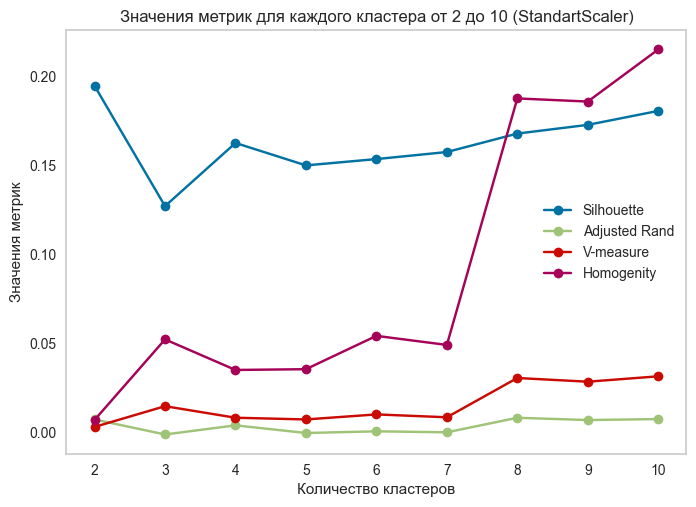

In [120]:
cluster_range = range(2, 11)

silhouette_arr = []
ari_arr = []
vms_arr = []
homogenity_arr = []

for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(scaled)

    pred = labels

    silhouette_arr.append(silhouette_score(scaled, labels))
    ari_arr.append(metrics.adjusted_rand_score(true, pred))
    vms_arr.append(metrics.v_measure_score(true, pred))
    homogenity_arr.append(metrics.homogeneity_score(true, pred))

plt.plot(cluster_range, silhouette_arr, label='Silhouette', marker='o')
plt.plot(cluster_range, ari_arr, label='Adjusted Rand', marker='o')
plt.plot(cluster_range, vms_arr, label='V-measure', marker='o')
plt.plot(cluster_range, homogenity_arr, label='Homogenity', marker='o')

plt.xlabel('Количество кластеров')
plt.ylabel('Значения метрик')
plt.title('Значения метрик для каждого кластера от 2 до 10 (StandartScaler)')
plt.legend()
plt.grid()
plt.show()

 Коэффициент силуэта принимает наибольшее значение при k = 2, что свидетельствует о наилучшем разделении данных на кластеры в данном случае. При увеличении числа кластеров значение силуэта снижается, однако начиная примерно с k = 5 наблюдается его постепенный рост, что указывает на частичное улучшение структуры кластеров, хотя максимального качества, достигнутого при двух кластерах, достичь не удаётся.
Метрики V-measure и Homogeneity в целом демонстрируют тенденцию к росту по мере увеличения количества кластеров, при этом наиболее заметный скачок наблюдается при k = 8. Это говорит о повышении однородности кластеров и более согласованном распределении объектов внутри них. Вместе с тем рост этих показателей не сопровождается сопоставимым увеличением коэффициента силуэта, что может указывать на дробление данных без существенного улучшения их разделимости.
Значения Adjusted Rand Index остаются близкими к нулю для всех рассматриваемых значений числа кластеров, что является ожидаемым результатом в условиях отсутствия истинных меток классов и подтверждает ограниченную применимость данной метрики для оценки качества неконтролируемой кластеризации. В целом, с точки зрения коэффициента силуэта оптимальным числом кластеров является k = 2, тогда как использование большего количества кластеров может быть оправдано лишь в случае необходимости более детальной сегментации данных, но без значительного выигрыша в качестве кластеризации.

7. Выполнить нормализацию данных с помощью MinMaxScaler, MaxAbsScaler и сравнить нормализованных с помощью StandardScaler.

Для начала были импортированы методы преобразования данных

In [121]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

Затем с помощью `MinMaxScaler` данные были нормализированы и выведены метрики для 2-10 кластеров, аналогично пункту 6 доп. заданий

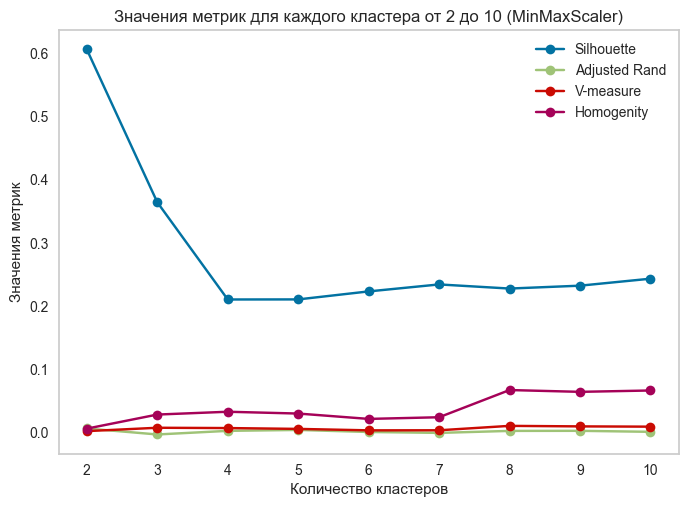

In [122]:
num_df=df.select_dtypes(exclude=['object']).drop('fraud', axis=1)
scaler=MinMaxScaler()
scaled=scaler.fit_transform(num_df)
cluster_range = range(2, 11)

silhouette_arr = []
ari_arr = []
vms_arr = []
homogenity_arr = []

for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(scaled)

    pred = labels

    silhouette_arr.append(silhouette_score(scaled, labels))
    ari_arr.append(metrics.adjusted_rand_score(true, pred))
    vms_arr.append(metrics.v_measure_score(true, pred))
    homogenity_arr.append(metrics.homogeneity_score(true, pred))

plt.plot(cluster_range, silhouette_arr, label='Silhouette', marker='o')
plt.plot(cluster_range, ari_arr, label='Adjusted Rand', marker='o')
plt.plot(cluster_range, vms_arr, label='V-measure', marker='o')
plt.plot(cluster_range, homogenity_arr, label='Homogenity', marker='o')

plt.xlabel('Количество кластеров')
plt.ylabel('Значения метрик')
plt.title('Значения метрик для каждого кластера от 2 до 10 (MinMaxScaler)')
plt.legend()
plt.grid()
plt.show()

На графике показана зависимость значений метрик качества кластеризации от количества кластеров в диапазоне от 2 до 10 при использовании алгоритма K-means с предварительным масштабированием данных с помощью MinMaxScaler. Наиболее высокое значение коэффициента силуэта наблюдается при k = 2, что указывает на чёткое разделение данных на два кластера. При увеличении числа кластеров значение силуэта резко снижается и далее изменяется незначительно, оставаясь на умеренном уровне, что свидетельствует об отсутствии существенного улучшения качества кластеризации при большем количестве кластеров.
Метрики V-measure и Homogeneity в целом демонстрируют невысокие значения для всех рассмотренных значений k, однако при k = 8–10 наблюдается их небольшой рост, что указывает на повышение однородности кластеров при более детальной сегментации данных. При этом рост данных метрик не сопровождается значительным увеличением коэффициента силуэта, что говорит о дроблении кластеров без существенного улучшения их разделимости.
Значения Adjusted Rand Index остаются близкими к нулю на всём диапазоне числа кластеров, что является ожидаемым результатом в условиях отсутствия истинных меток классов и подтверждает ограниченную применимость данной метрики для оценки качества неконтролируемой кластеризации. В целом, результаты показывают, что при использовании MinMaxScaler оптимальным числом кластеров с точки зрения коэффициента силуэта является k = 2, тогда как увеличение числа кластеров не приводит к заметному улучшению качества кластеризации.

Затем преобразуем данные с помощью `MaxAbsScaler`

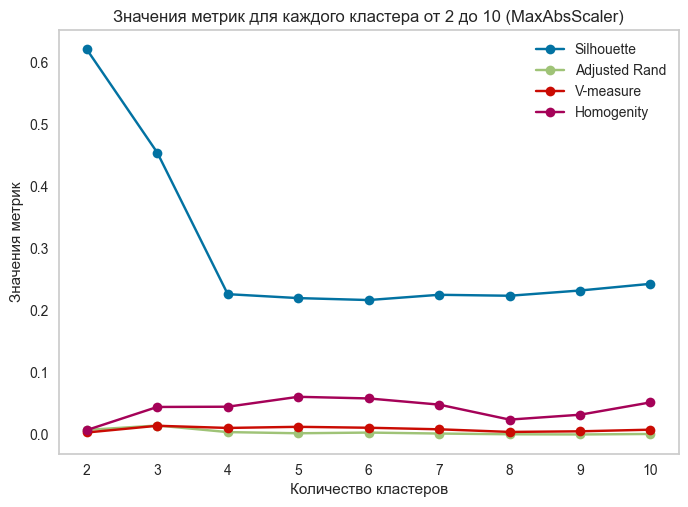

In [124]:
num_df=df.select_dtypes(exclude=['object']).drop('fraud', axis=1)
scaler=MaxAbsScaler()
scaled=scaler.fit_transform(num_df)
cluster_range = range(2, 11)

silhouette_arr = []
ari_arr = []
vms_arr = []
homogenity_arr = []

for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(scaled)

    pred = labels

    silhouette_arr.append(silhouette_score(scaled, labels))
    ari_arr.append(metrics.adjusted_rand_score(true, pred))
    vms_arr.append(metrics.v_measure_score(true, pred))
    homogenity_arr.append(metrics.homogeneity_score(true, pred))

plt.plot(cluster_range, silhouette_arr, label='Silhouette', marker='o')
plt.plot(cluster_range, ari_arr, label='Adjusted Rand', marker='o')
plt.plot(cluster_range, vms_arr, label='V-measure', marker='o')
plt.plot(cluster_range, homogenity_arr, label='Homogenity', marker='o')

plt.xlabel('Количество кластеров')
plt.ylabel('Значения метрик')
plt.title('Значения метрик для каждого кластера от 2 до 10 (MaxAbsScaler)')
plt.legend()
plt.grid()
plt.show()

На графике представлена зависимость значений метрик качества кластеризации от количества кластеров в диапазоне от 2 до 10 при использовании алгоритма K-means с предварительным масштабированием данных с помощью MaxAbsScaler. Наибольшее значение коэффициента силуэта наблюдается при k = 2, что указывает на наиболее чёткое разделение данных на два кластера. При дальнейшем увеличении числа кластеров значение силуэта резко снижается и затем остаётся примерно на одном уровне, демонстрируя лишь незначительные колебания, что свидетельствует об отсутствии существенного улучшения качества кластеризации при увеличении числа кластеров.
Метрики V-measure и Homogeneity принимают невысокие значения для всех рассматриваемых значений k, однако можно отметить умеренный рост показателя Homogeneity при k = 5–6, что указывает на некоторое повышение однородности кластеров при данном числе кластеров. При дальнейшем увеличении k значения этих метрик снижаются или изменяются незначительно, что также говорит об отсутствии выраженного улучшения структуры кластеров.
Значения Adjusted Rand Index остаются близкими к нулю во всём диапазоне числа кластеров, что является ожидаемым результатом в условиях отсутствия истинных меток классов и подтверждает ограниченную применимость данной метрики для оценки качества неконтролируемой кластеризации. В целом результаты показывают, что при использовании MaxAbsScaler оптимальным числом кластеров с точки зрения коэффициента силуэта является k = 2, тогда как увеличение числа кластеров не приводит к значимому улучшению качества кластеризации и может приводить лишь к избыточному дроблению данных.

Для удобства нанесем все на 1 график

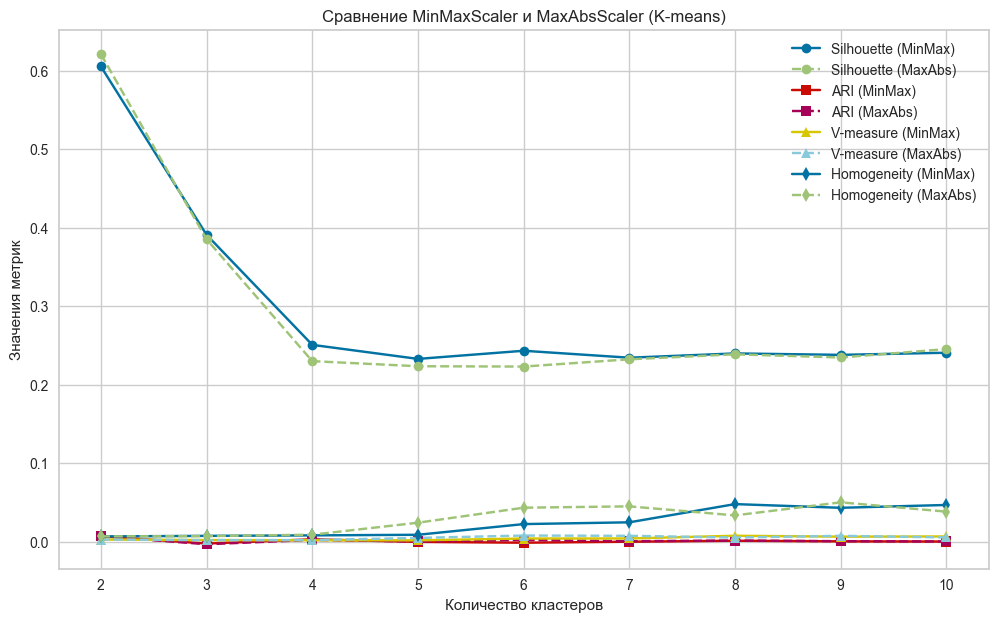

In [123]:

num_df = df.select_dtypes(exclude=['object']).drop('fraud', axis=1)
cluster_range = range(2, 11)

scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'MaxAbsScaler': MaxAbsScaler()
}

results = {
    'MinMaxScaler': {'sil': [], 'ari': [], 'vms': [], 'hom': []},
    'MaxAbsScaler': {'sil': [], 'ari': [], 'vms': [], 'hom': []}
}

for scaler_name, scaler in scalers.items():
    scaled = scaler.fit_transform(num_df)

    for n in cluster_range:
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        labels = kmeans.fit_predict(scaled)

        results[scaler_name]['sil'].append(silhouette_score(scaled, labels))
        results[scaler_name]['ari'].append(metrics.adjusted_rand_score(true, labels))
        results[scaler_name]['vms'].append(metrics.v_measure_score(true, labels))
        results[scaler_name]['hom'].append(metrics.homogeneity_score(true, labels))
plt.figure(figsize=(12, 7))


plt.plot(cluster_range, results['MinMaxScaler']['sil'],
         marker='o', linestyle='-', label='Silhouette (MinMax)')
plt.plot(cluster_range, results['MaxAbsScaler']['sil'],
         marker='o', linestyle='--', label='Silhouette (MaxAbs)')


plt.plot(cluster_range, results['MinMaxScaler']['ari'],
         marker='s', linestyle='-', label='ARI (MinMax)')
plt.plot(cluster_range, results['MaxAbsScaler']['ari'],
         marker='s', linestyle='--', label='ARI (MaxAbs)')


plt.plot(cluster_range, results['MinMaxScaler']['vms'],
         marker='^', linestyle='-', label='V-measure (MinMax)')
plt.plot(cluster_range, results['MaxAbsScaler']['vms'],
         marker='^', linestyle='--', label='V-measure (MaxAbs)')


plt.plot(cluster_range, results['MinMaxScaler']['hom'],
         marker='d', linestyle='-', label='Homogeneity (MinMax)')
plt.plot(cluster_range, results['MaxAbsScaler']['hom'],
         marker='d', linestyle='--', label='Homogeneity (MaxAbs)')

plt.xlabel('Количество кластеров')
plt.ylabel('Значения метрик')
plt.title('Сравнение MinMaxScaler и MaxAbsScaler (K-means)')
plt.legend()
plt.grid(True)
plt.show()



При сравнении графиков, полученных с использованием MinMaxScaler и MaxAbsScaler, можно выделить как общие тенденции, так и различия в поведении метрик качества кластеризации. В обоих случаях коэффициент силуэта достигает максимального значения при числе кластеров k = 2, что указывает на наиболее качественное разделение данных именно на два кластера независимо от выбранного метода масштабирования. При дальнейшем увеличении числа кластеров значение силуэта в обоих вариантах резко снижается, а затем стабилизируется, изменяясь лишь незначительно, что свидетельствует об отсутствии существенного улучшения качества кластеризации при более детальной сегментации данных.

В то же время при использовании MaxAbsScaler значения коэффициента силуэта при малом числе кластеров, в частности при k = 2 и k = 3, несколько выше, чем при использовании MinMaxScaler, что говорит о более выраженной структуре данных после такого способа масштабирования. Для больших значений k поведение коэффициента силуэта в обоих случаях становится схожим, и различия между методами масштабирования практически сглаживаются.

Метрики V-measure и Homogeneity в обоих вариантах принимают относительно низкие значения, однако при использовании MinMaxScaler наблюдается более заметный рост этих показателей при k = 8–10. Это указывает на повышение однородности кластеров при большем числе кластеров, хотя данный рост не сопровождается улучшением коэффициента силуэта. В случае MaxAbsScaler изменения данных метрик выражены слабее и носят более сглаженный характер, что говорит о меньшей склонности модели к дроблению данных на формально более однородные, но плохо разделённые кластеры.

Значения Adjusted Rand Index остаются близкими к нулю для обоих графиков на всём диапазоне числа кластеров, что является ожидаемым результатом при отсутствии истинных меток классов и подтверждает ограниченную применимость данной метрики для оценки качества неконтролируемой кластеризации. В целом можно сделать вывод, что оба метода масштабирования приводят к схожим результатам и указывают на оптимальное число кластеров k = 2, однако MaxAbsScaler обеспечивает несколько лучшее качество кластеризации при малом числе кластеров, тогда как MinMaxScaler демонстрирует более выраженную тенденцию к увеличению однородности кластеров при большем числе кластеров без существенного улучшения их разделимости.


10. Выполнить кластеризацию с помощью метода DBSCAN. Добавить описание
метода (теор.часть). Сравнить результаты с полученными ранее.

Данный код реализует полный процесс кластеризации данных с использованием алгоритма DBSCAN, который относится к методам плотностной кластеризации и позволяет выявлять кластеры произвольной формы, а также обнаруживать шумовые объекты. В основе работы DBSCAN лежат два ключевых параметра: `eps`, определяющий радиус окрестности точки, и `min_samples`, задающий минимальное количество объектов в этой окрестности, необходимое для формирования плотного кластера. В отличие от алгоритма K-means, DBSCAN не требует заранее задавать число кластеров, однако является чувствительным к масштабу признаков и выбору параметров, поэтому предварительная нормализация данных является обязательной.

На первом этапе из исходного датафрейма отбираются числовые признаки, при этом целевая переменная `fraud` исключается из набора данных и сохраняется отдельно для последующего расчёта внешних метрик качества. Далее все признаки масштабируются с помощью StandardScaler, что обеспечивает корректное вычисление расстояний между объектами. Затем выполняется перебор значений параметра `eps` в заданном диапазоне при фиксированном значении `min_samples = 10`. Для каждого значения `eps` модель DBSCAN обучается на масштабированных данных, после чего определяется количество найденных кластеров, число шумовых объектов и вычисляются метрики качества кластеризации. Коэффициент силуэта рассчитывается только для не-шумовых объектов и только в случае, если было обнаружено не менее двух кластеров, тогда как метрики Adjusted Rand Index, V-measure и Homogeneity используются для оценки согласованности полученной кластеризации с истинной разметкой данных.

Результаты перебора параметра `eps` визуализируются с помощью графиков зависимости метрик качества, количества кластеров и доли шумовых объектов от значения `eps`, что позволяет наглядно оценить влияние параметров на структуру кластеров. На основе полученных значений автоматически выбирается оптимальное значение `eps`, соответствующее наилучшему значению коэффициента силуэта, либо, в случае его отсутствия, значению с наибольшим числом кластеров. После этого DBSCAN повторно обучается с выбранными параметрами, выводятся итоговые метрики качества и выполняется визуализация кластеризации в двумерном пространстве выбранных признаков. Таким образом, код обеспечивает комплексный анализ кластеризации с помощью DBSCAN, включая подбор параметров, количественную оценку качества и наглядную интерпретацию результатов.


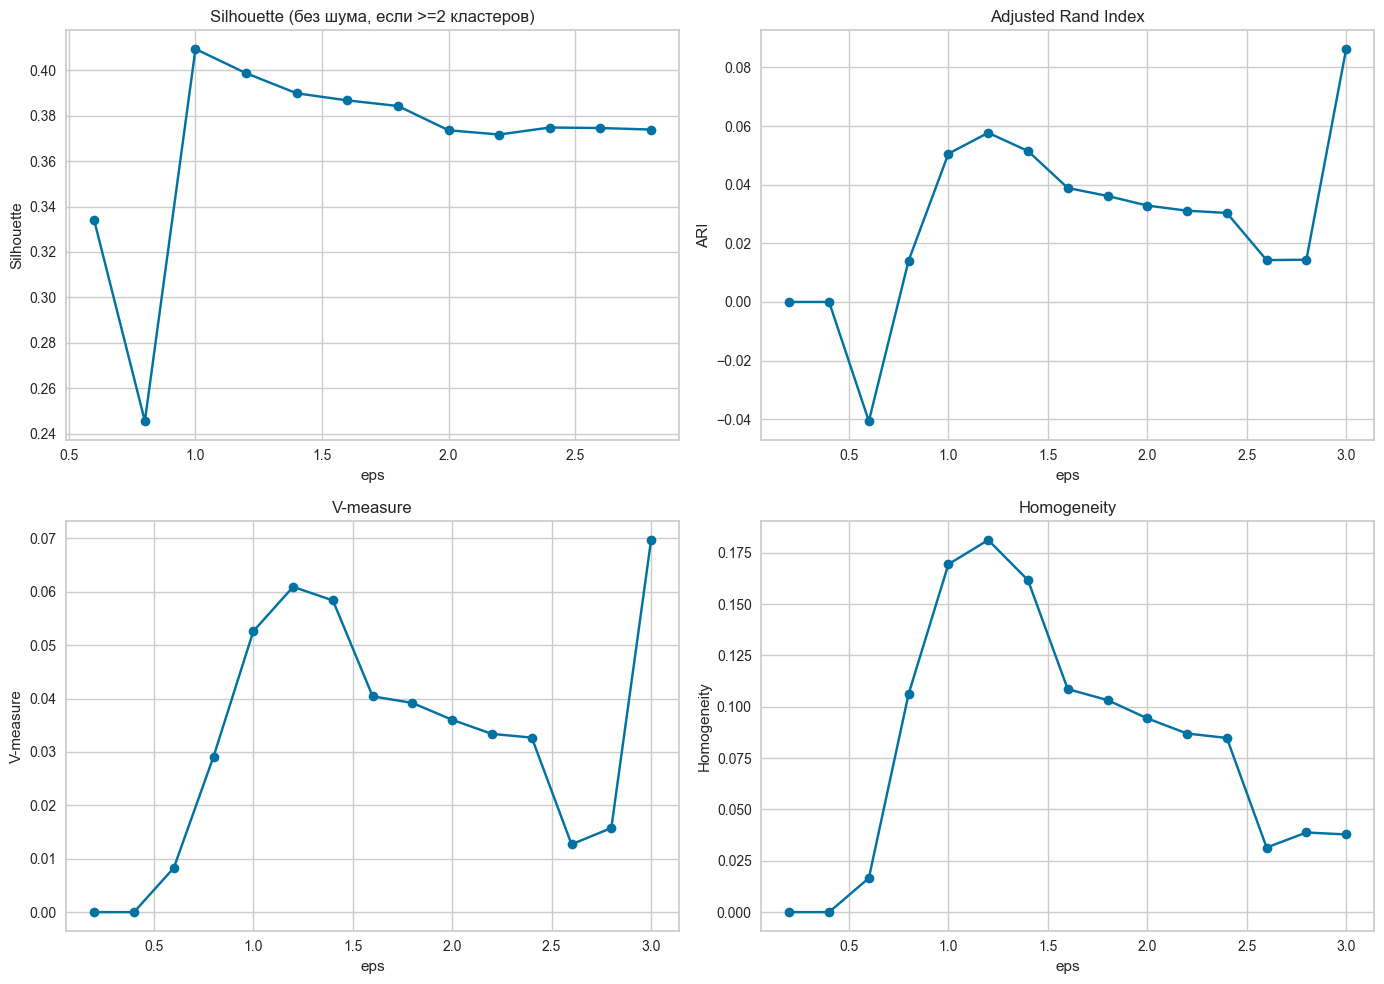

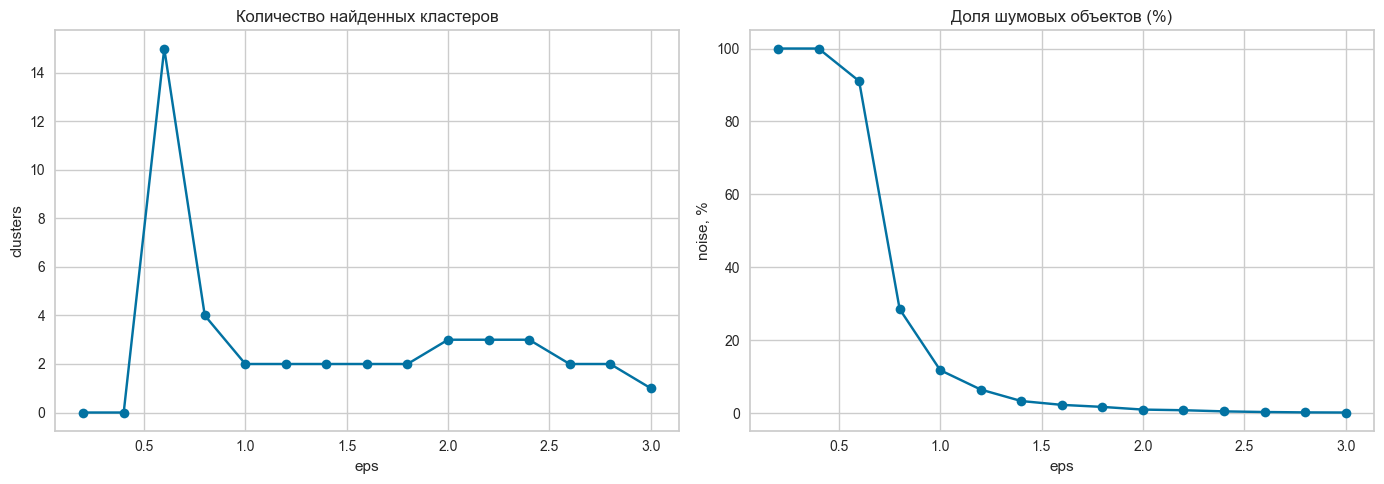

Выбранный eps: 1.00, min_samples=10
Кластеры: 2, шум: 338 (11.8%)
Silhouette (без шума): 0.4093
ARI: 0.0506
V-measure: 0.0526
Homogeneity: 0.1694


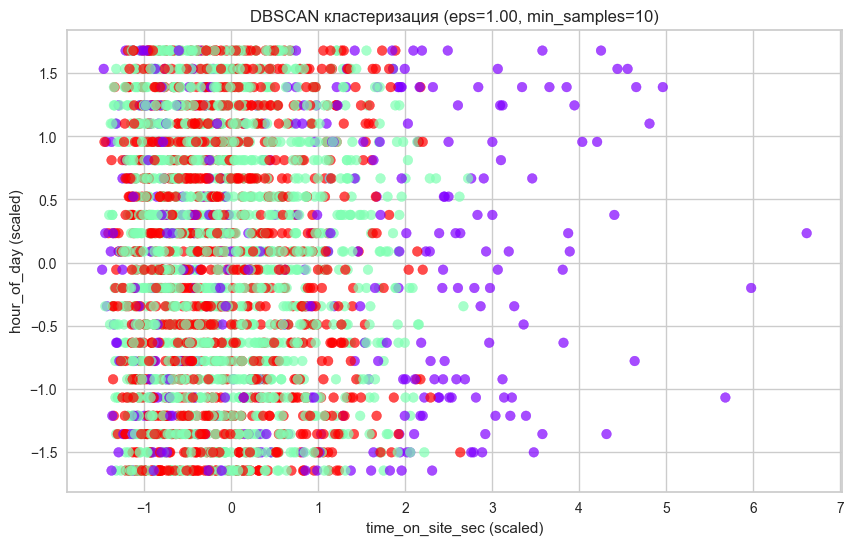

In [ ]:

from sklearn.cluster import DBSCAN
_df = df.select_dtypes(exclude=['object']).drop('fraud', axis=1)
true = df['fraud'].values 


scaled = StandardScaler().fit_transform(num_df)


eps_grid = np.arange(0.2, 3.1, 0.2)  
min_samples = 10
N = scaled.shape[0]

silhouette_arr = []
ari_arr = []
vms_arr = []
hom_arr = []
clusters_arr = []
noise_arr = []

for eps in eps_grid:
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    clusters_arr.append(n_clusters)
    noise_arr.append(n_noise)


    mask = labels != -1
    labels_in = labels[mask]

    if n_clusters >= 2 and mask.sum() > 1 and len(set(labels_in)) >= 2:
        sil = silhouette_score(scaled[mask], labels_in)
    else:
        sil = np.nan
    silhouette_arr.append(sil)


    ari_arr.append(metrics.adjusted_rand_score(true, labels))
    vms_arr.append(metrics.v_measure_score(true, labels))
    hom_arr.append(metrics.homogeneity_score(true, labels))


plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(eps_grid, silhouette_arr, marker='o')
plt.title('Silhouette (без шума, если >=2 кластеров)')
plt.xlabel('eps')
plt.ylabel('Silhouette')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(eps_grid, ari_arr, marker='o')
plt.title('Adjusted Rand Index')
plt.xlabel('eps')
plt.ylabel('ARI')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(eps_grid, vms_arr, marker='o')
plt.title('V-measure')
plt.xlabel('eps')
plt.ylabel('V-measure')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(eps_grid, hom_arr, marker='o')
plt.title('Homogeneity')
plt.xlabel('eps')
plt.ylabel('Homogeneity')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(eps_grid, clusters_arr, marker='o')
plt.title('Количество найденных кластеров')
plt.xlabel('eps')
plt.ylabel('clusters')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(eps_grid, np.array(noise_arr) / N * 100, marker='o')
plt.title('Доля шумовых объектов (%)')
plt.xlabel('eps')
plt.ylabel('noise, %')
plt.grid(True)

plt.tight_layout()
plt.show()

valid_idx = np.where(~np.isnan(silhouette_arr))[0]
if len(valid_idx) > 0:
    best_idx = valid_idx[np.nanargmax(np.array(silhouette_arr)[valid_idx])]
    best_eps = eps_grid[best_idx]
else:

    best_idx = int(np.argmax(clusters_arr))
    best_eps = eps_grid[best_idx]

print(f"Выбранный eps: {best_eps:.2f}, min_samples={min_samples}")

dbscan_best = DBSCAN(eps=best_eps, min_samples=min_samples)
labels_best = dbscan_best.fit_predict(scaled)

n_clusters_best = len(set(labels_best)) - (1 if -1 in labels_best else 0)
n_noise_best = np.sum(labels_best == -1)
print(f"Кластеры: {n_clusters_best}, шум: {n_noise_best} ({n_noise_best/N*100:.1f}%)")


mask = labels_best != -1
labels_in = labels_best[mask]
if n_clusters_best >= 2 and mask.sum() > 1 and len(set(labels_in)) >= 2:
    sil_best = silhouette_score(scaled[mask], labels_in)
    print(f"Silhouette (без шума): {sil_best:.4f}")
else:
    print("Silhouette не вычисляется (менее 2 кластеров после удаления шума)")

print(f"ARI: {metrics.adjusted_rand_score(true, labels_best):.4f}")
print(f"V-measure: {metrics.v_measure_score(true, labels_best):.4f}")
print(f"Homogeneity: {metrics.homogeneity_score(true, labels_best):.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(scaled[:, 2], scaled[:, 4], c=labels_best, cmap='rainbow', alpha=0.7)
plt.title(f'DBSCAN кластеризация (eps={best_eps:.2f}, min_samples={min_samples})')
plt.xlabel('time_on_site_sec (scaled)')
plt.ylabel('hour_of_day (scaled)')
plt.grid(True)
plt.show()


На представленных графиках показана зависимость метрик качества кластеризации DBSCAN от значения параметра `eps`. Коэффициент силуэта, рассчитанный без учёта шумовых объектов, достигает наибольшего значения при `eps` примерно равном 1.0, что указывает на наиболее чёткое разделение кластеров и хорошую компактность объектов внутри них. При меньших значениях `eps` наблюдается резкое ухудшение качества, что связано с недостаточной плотностью для формирования устойчивых кластеров, тогда как при дальнейшем увеличении `eps` значение силуэта постепенно снижается и стабилизируется, что может свидетельствовать об укрупнении кластеров и потере их чёткости.

Метрика Adjusted Rand Index демонстрирует низкие значения во всём диапазоне `eps`, однако заметный рост наблюдается в интервале от 0.8 до 1.2, а максимальное значение достигается при больших значениях `eps`. Это говорит о том, что при определённых настройках DBSCAN кластеризация в большей степени согласуется с истинной разметкой, хотя в целом уровень совпадения остаётся невысоким. Аналогичную динамику показывают метрики V-measure и Homogeneity: обе метрики достигают своих максимальных значений в диапазоне `eps` около 1.0–1.2, что указывает на наибольшую однородность кластеров и лучшую согласованность с эталонными классами именно при этих значениях параметра.

В совокупности анализ графиков показывает, что наиболее сбалансированное качество кластеризации достигается при `eps` в районе 1.0–1.2, где одновременно наблюдаются высокие значения коэффициента силуэта и локальные максимумы внешних метрик качества. При меньших значениях `eps` алгоритм слишком строго трактует плотность и относит большую часть объектов к шуму, а при больших значениях происходит чрезмерное объединение данных в менее информативные кластеры.



В случае **DBSCAN** (eps = 1.0, min_samples = 10) наблюдается формирование нескольких плотных областей, а также заметное количество объектов, отнесённых к шуму. Алгоритм не стремится разделить все точки на кластеры и оставляет разреженные области без кластерной принадлежности, что хорошо видно по точкам, находящимся на больших значениях *time_on_site_sec*. Это свидетельствует о способности DBSCAN выявлять выбросы и учитывать неоднородность плотности данных. Кластеры имеют нерегулярную форму и отражают локальные сгущения наблюдений, что соответствует теоретическим особенностям алгоритма плотностной кластеризации.

Визуализация **K-means** с двумя кластерами демонстрирует принципиально иной подход. Все объекты без исключения распределяются между двумя кластерами, при этом граница между ними является условной и определяется расстоянием до центров кластеров. Центры кластеров расположены в областях наибольшей плотности данных, однако алгоритм не способен выделить шумовые объекты и вынужден относить даже удалённые точки к одному из кластеров. В результате кластеры имеют более простую, близкую к линейной структуру и не учитывают локальные особенности распределения данных.

Таким образом, сравнение показывает, что **DBSCAN** более гибко отражает естественную структуру данных, выявляя плотные группы и выбросы, тогда как **K-means** обеспечивает более простое и глобальное разбиение, подходящее для данных с относительно однородной плотностью и чётким разделением на заданное число кластеров. В рассматриваемом случае DBSCAN позволяет лучше выявить локальные структуры и шум, а K-means — получить общее разбиение данных на крупные сегменты, что делает оба алгоритма взаимодополняющими в анализе структуры данных.

В любом случае, расположение точек настолько неудобно, что тяжело выделить адекватно кластеры в этой задаче
